**Table of contents**<a id='toc0_'></a>    
- [Elimination event segmentation](#toc1_1_)    
    - [Setup](#toc1_1_1_)    
    - [Dataset](#toc1_1_2_)    
    - [Training and eval](#toc1_1_3_)    
    - [Sample prediction](#toc1_1_4_)    
    - [Conclusions](#toc1_1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Elimination event segmentation](#toc0_)

Trying out Meta's Segment Anything Model (SAM) to try to segment out elimination events from video frames.

With this in place, we can start with some simple rules to classify videos and possibly trim clips.

### <a id='toc1_1_1_'></a>[Setup](#toc0_)

In [2]:
#| default_exp segmentation.utils
%matplotlib inline

In [31]:
#| export
import dataclasses
import enum
from io import BytesIO
import os
import pathlib
import random
from urllib.parse import urlparse

from typing import List

import boto3
import matplotlib.pyplot as plt
import mlflow
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch
from torchvision.transforms import transforms


from csgo_clips_autotrim.experiment_utils.secrets import Secrets
from csgo_clips_autotrim.experiment_utils.references import engine

In [25]:
device = "cuda"

DATA_DIR = pathlib.Path('/data/autotrim/datasets/')
FRAMES_DATA_DIR = DATA_DIR / 'frames'
COCO_DATASET_DIR = DATA_DIR / 'frames-annotated-coco-fixed-batch-02'

assert FRAMES_DATA_DIR.exists() and FRAMES_DATA_DIR.is_dir(), "Frames dataset directory does not exist"
assert COCO_DATASET_DIR.exists() and COCO_DATASET_DIR.is_dir(), "COCO dataset directory does not exist"

In [6]:
mlflow.set_tracking_uri('https://mlflow.tenzing.shkhr.ovh')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'https://minio-api.tenzing.shkhr.ovh'
EXPERIMENT_NAME = 'csgo-elimination-segmentation'
ARTIFACT_LOCATION = f's3://mlflow/{EXPERIMENT_NAME}'

EXPERIMENT_DIR = pathlib.Path('/data/kaggle') / EXPERIMENT_NAME
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
# If the experiment does not exist, create the experiment for the first time and
# set the artifact location.
if mlflow.get_experiment_by_name(EXPERIMENT_NAME) is None:
    mlflow.create_experiment(EXPERIMENT_NAME, artifact_location=ARTIFACT_LOCATION)

experiment = mlflow.set_experiment(EXPERIMENT_NAME)

In [8]:
#| export
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)



def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def bbox_to_mask(bbox: List, img_h: int, img_w: int):
    left_x, top_y, bbox_w, bbox_h = bbox
    right_x = left_x + bbox_w
    bottom_y = top_y + bbox_h

    mask = np.zeros((img_h, img_w))

    mask[int(top_y):int(bottom_y),  int(left_x):int(right_x)] = 1

    return mask

def box_to_mask(box: List, img_h: int, img_w: int):
    left_x, top_y, right_x, bottom_y = box

    mask = np.zeros((img_h, img_w))

    mask[int(top_y):int(bottom_y),  int(left_x):int(right_x)] = 1

    return mask

### <a id='toc1_1_2_'></a>[Dataset](#toc0_)

Load a dataset in COCO format and evaluate SAM's performance compared to labelled samples.

In [9]:
ANNOTATIONS_PATH = COCO_DATASET_DIR / 'result.json'

In [10]:
#| export
secrets = Secrets.load()

def get_minio_client():
  s3 = boto3.resource('s3', 
    endpoint_url='https://minio-api.tenzing.shkhr.ovh',
    aws_access_key_id=secrets.MINIO_AWS_ACCESS_KEY_ID,
    aws_secret_access_key=secrets.MINIO_AWS_SECRET_ACCESS_KEY,
    aws_session_token=None,
    config=boto3.session.Config(signature_version='s3v4')
  )
  return s3.meta.client

s3_client = get_minio_client()

In [11]:
#| export
def load_image_from_s3(uri: str) -> Image.Image:
    clean_uri = uri.replace('\\', '')
    parsed_uri = urlparse(clean_uri)
    bucket_name, path = parsed_uri.hostname, parsed_uri.path[1:]

    response = s3_client.get_object(Bucket=bucket_name, Key=path)
    img_data = response['Body'].read()
    img = Image.open(BytesIO(img_data))

    return img

In [12]:
#| export
class EliminationEventsDataset(torch.utils.data.Dataset):
    """ Torch dataset of the annotated elimination events.
    """
    class Categories(enum.Enum):
        ELIMINATED = 0
        ELIMINATION_EVENT = 1
        ELIMINATOR = 2
        WEAPON = 3
        
    def __init__(self, annotation_file_path: str, transforms=None, event_types = [Categories.ELIMINATION_EVENT]):
        self.transforms = transforms
        self.coco = COCO(annotation_file_path)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.event_types = event_types

    def _load_image(self, id: int) -> Image.Image:
        img_uri = self.coco.loadImgs(id)[0]['file_name']
        return load_image_from_s3(img_uri)
    
    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # Load the input image
        img = self._load_image(img_id)

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Only focus on elim
        categories = [EliminationEventsDataset.Categories(ann['category_id']) for ann in coco_annotation]
        elimination_event_ids = [i for i in range(num_objs) if categories[i] in self.event_types]

        num_objs = len(elimination_event_ids)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in elimination_event_ids:
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        if not elimination_event_ids:
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []

        for i in elimination_event_ids:
            areas.append(coco_annotation[i]['area'])

        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, my_annotation = self.transforms((img, my_annotation))

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [13]:
dataset = EliminationEventsDataset(annotation_file_path=ANNOTATIONS_PATH)
print('Total number of samples: ', len(dataset))

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
Total number of samples:  742


In [14]:
ANNOTATIONS_PATH

PosixPath('/data/autotrim/datasets/frames-annotated-coco-fixed-batch-02/result.json')

In [15]:
sample = random.choice(dataset)
img, anns = sample

print(len(anns))

for i in range(len(anns['boxes'])):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    mask = box_to_mask(anns['boxes'][i], img.height, img.width)
    show_mask(mask, plt.gca())
    category = EliminationEventsDataset.Categories(anns['labels'][i].numpy())
    plt.title(f"Mask {i+1}, category: {category}", fontsize=18)
    plt.axis('off')
    plt.show()  

5


### <a id='toc1_1_3_'></a>[Training and eval](#toc0_)

In [16]:
from csgo_clips_autotrim.preprocessing import TopRightQuadrant, ImageToTensor, Grayscale

In [17]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1

torch.manual_seed(42)

train_size = int(TRAIN_RATIO  * len(dataset))
val_size = int(VAL_RATIO * len(dataset))
test_size = len(dataset) - (train_size + val_size)

# Define the preprocessing transformations
preprocess = transforms.Compose([
    TopRightQuadrant(),  # Use the top right quadrant only
    Grayscale(),
    ImageToTensor(),
])

dataset = EliminationEventsDataset(annotation_file_path=ANNOTATIONS_PATH, transforms=preprocess)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [18]:
#| export
# Define a custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [35]:
# Load a pre-trained Mask R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

/home/shikhar/.pyenv/versions/csgo-clips-autotrim-py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shikhar/.pyenv/versions/csgo-clips-autotrim-py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# Modify the last fully connected layer for the number of classes in your dataset
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


# Set device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [37]:
#| export
@dataclasses.dataclass
class EvaluationMetrics:
    coco_map: float
    voc_map: float

    def log(self):
        metrics = dataclasses.asdict(self)
        mlflow.log_metrics(metrics)

    @classmethod
    def from_evaluator(cls, evaluator) -> 'EvaluationMetrics':
        coco_map = evaluator.coco_eval['bbox'].stats[0]
        voc_map = evaluator.coco_eval['bbox'].stats[1]

        return EvaluationMetrics(coco_map, voc_map)

Epoch [1/10], Loss: 0.6801
Epoch [2/10], Loss: 0.6296
Epoch [3/10], Loss: 0.6240
Epoch [4/10], Loss: 0.6230
Epoch [5/10], Loss: 0.6225
Epoch [6/10], Loss: 0.6229
Epoch [7/10], Loss: 0.6221
Epoch [8/10], Loss: 0.6214
Epoch [9/10], Loss: 0.6202
Epoch [10/10], Loss: 0.6217
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:26  model_time: 0.3738 (0.3738)  evaluator_time: 0.0032 (0.0032)  time: 1.3825  data: 1.0040  max mem: 2209
Test:  [18/19]  eta: 0:00:00  model_time: 0.3684 (0.3620)  evaluator_time: 0.0015 (0.0015)  time: 0.4257  data: 0.0609  max mem: 2209
Test: Total time: 0:00:08 (0.4274 s / it)
Averaged stats: model_time: 0.3684 (0.3620)  evaluator_time: 0.0015 (0.0015)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.590
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.204
 

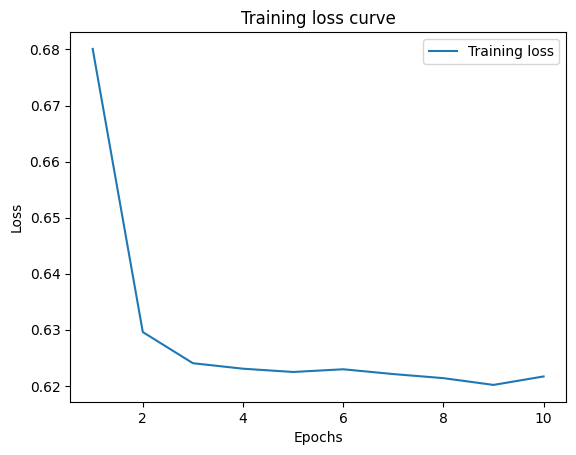

In [38]:
train_fasterrcnn = False


with mlflow.start_run(run_name='fasterrcnn',
                      description='Pretrained faster RCNN with fully connected layers unfrozen for transfer learning.',
                      experiment_id=experiment.experiment_id) as run:
    # Define optimizer and loss function.
    params = {
        'learning_rate': 0.01,
        'momentum': 0.9,
        'loss_fn': 'cross_entropy',
        'num_epochs': 10
    }

    mlflow.log_params(params)

    optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])
    criterion = torch.nn.CrossEntropyLoss()

    loss_table = []

    # Training loop
    for epoch in range(params['num_epochs']):
        model.train()
        total_loss = 0.0
        
        for images, targets in train_data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_data_loader)
        loss_table.append(avg_loss)

        print(f'Epoch [{epoch+1}/{params["num_epochs"]}], Loss: {avg_loss:.4f}')

    RUN_DIR = EXPERIMENT_DIR / run.info.run_id
    RUN_DIR.mkdir(parents=True, exist_ok=False)
    MODEL_PATH = RUN_DIR / 'model.pkl'

    torch.save(model.state_dict(), MODEL_PATH)

    # Save loss curve.
    plt.plot(range(1, params['num_epochs'] + 1), loss_table, label='Training loss')
    plt.title('Training loss curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig(RUN_DIR / 'loss_curve.png')

    mlflow.log_artifacts(RUN_DIR)

    evaluator = engine.evaluate(model, val_data_loader, device=device)
    metrics = EvaluationMetrics.from_evaluator(evaluator)
    metrics.log()

### <a id='toc1_1_4_'></a>[Sample prediction](#toc0_)

In [72]:
img, targets = random.choice(val_dataset)

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
img = Image.fromarray(img.mul(255).byte().numpy().reshape(360, 640))

1


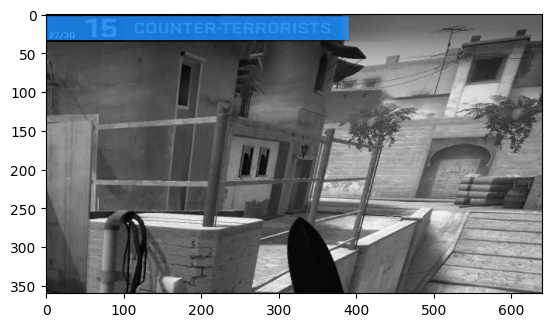

In [73]:
# plt.imshow(img, cmap='grayscale')
plt.imshow(img, cmap='gray')

print(len(prediction[0]['boxes']))

for box in prediction[0]['boxes']:
    mask = box_to_mask(box, img.height, img.width)
    show_mask(mask, plt.gca())
    # plt.figure(figsize=(10,10))
    show_mask(mask, plt.gca())
    # plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    # plt.axis('off')

plt.show()  

### <a id='toc1_1_5_'></a>[Conclusions](#toc0_)

The OOB performance of the model is understandably very poor.
While it is able to find the elimination events in some cases, in most cases, it commits the following types of errors:

1. Selecting a completely different region of the image as the answer: we'll retry by reducing the size of the frame passed in to the image to the top right quadrant, since elimination events are mostly restricted to that region.
2. Not being able to distinguish between individual events: This might be helped by image preprocessing like thresholding, edge detection etc. to provide as crisp decision boundary as possible to the model.